In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt

import math
from torch import nn, optim
import torch
import torch.nn.functional as F
from torch.autograd import Variable

from tqdm import tqdm
import warnings
warnings.filterwarnings("ignore")

In [2]:
def read_data():
    train_df = pd.read_csv('../data/ratings_train.csv')
    val_df = pd.read_csv('../data/ratings_vali.csv')

    return train_df, val_df

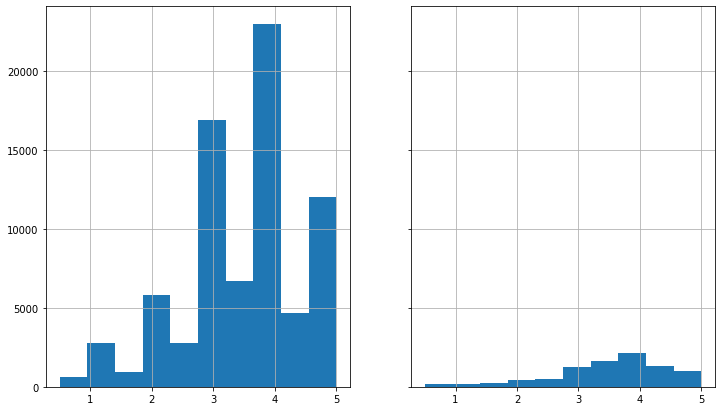

In [3]:
# 학습할 영화 데이터 분석
train_df, val_df = read_data()

fig, ax = plt.subplots(1, 2, sharex='col', sharey='row', figsize=(12,7))
ax = ax.ravel()

train_df['rating'].hist(ax=ax[0])
val_df['rating'].hist(ax=ax[1])

In [4]:
train_df['rating'].describe()

count    76083.000000
mean         3.547829
std          1.050560
min          0.500000
25%          3.000000
50%          4.000000
75%          4.000000
max          5.000000
Name: rating, dtype: float64

In [5]:
# 영화 데이터의 메타 정보를 확인한다
# movies_w_imgurl.csv
# tags.csv
movies_df = pd.read_csv('../data/movies_w_imgurl.csv')
movies_info_df = movies_df[['movieId','movieName','genres']].set_index('movieId')

movieName_dict = movies_info_df.to_dict()['movieName']
genres_dict = movies_info_df.to_dict()['genres']

In [6]:
movies_df['genres']

0       Adventure|Animation|Children|Comedy|Fantasy
1                        Adventure|Children|Fantasy
2                                    Comedy|Romance
3                              Comedy|Drama|Romance
4                                            Comedy
                           ...                     
9120                        Adventure|Drama|Romance
9121                Action|Adventure|Fantasy|Sci-Fi
9122                                    Documentary
9123                                         Comedy
9124                                    Documentary
Name: genres, Length: 9125, dtype: object

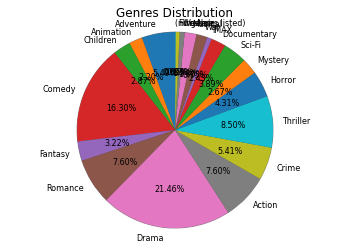

In [7]:
original_list = [x.split('|') for x in list(movies_df['genres'])]

flat_list = list(set([item for sublist in original_list for item in sublist]))

genres_count_dict = dict()
for idx, row in movies_df.iterrows():
    for genre_name in row['genres'].split('|'):
        if genre_name in genres_count_dict.keys():
            genres_count_dict[genre_name] += 1
        else:
            genres_count_dict[genre_name] = 1

genres_count_df = pd.DataFrame.from_dict(genres_count_dict, orient='index')
genres_count_df.columns = ['count']
genres_count_df

group_sizes = list(genres_count_df['count'].values)
group_names = list(genres_count_df.index)

plt.pie(group_sizes, 
            labels=group_names, 
            autopct='%1.2f%%',
        radius=20000,
           shadow=True,
           startangle=90,
           textprops={'fontsize':8})

plt.axis('equal')
plt.title('Genres Distribution')
plt.show()

In [8]:
def user_preference(userId):
    train_df, val_df = read_data()
    all_df = pd.concat([train_df, val_df], axis=0)

    all_df = all_df.set_index('userId')

    temp_df = all_df.loc[userId]
    temp_df['movieName'] = temp_df['movieId'].apply(lambda x: movieName_dict[x])
    temp_df['genres'] = temp_df['movieId'].apply(lambda x: genres_dict[x])
    temp_df = temp_df.sort_values(by='rating', ascending=False)
    
    return temp_df

In [9]:
user_preference(1)

,movieId,rating,movieName,genres
userId,,,,
1,1172,4.0,Cinema Paradiso (Nuovo cinema Paradiso) (1989),Drama
1,2105,4.0,Tron (1982),Action|Adventure|Sci-Fi
1,1953,4.0,"French Connection, The (1971)",Action|Crime|Thriller
1,1339,3.5,Dracula (Bram Stoker's Dracula) (1992),Fantasy|Horror|Romance|Thriller
1,3671,3.0,Blazing Saddles (1974),Comedy|Western
1,1029,3.0,Dumbo (1941),Animation|Children|Drama|Musical
1,1061,3.0,Sleepers (1996),Thriller
1,2150,3.0,"Gods Must Be Crazy, The (1980)",Adventure|Comedy
1,2455,2.5,"Fly, The (1986)",Drama|Horror|Sci-Fi|Thriller


In [10]:
user_preference(100)

,movieId,rating,movieName,genres
userId,,,,
100,1073,5.0,Willy Wonka & the Chocolate Factory (1971),Children|Comedy|Fantasy|Musical
100,32,5.0,Twelve Monkeys (a.k.a. 12 Monkeys) (1995),Mystery|Sci-Fi|Thriller
100,1,4.0,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
100,3,4.0,Grumpier Old Men (1995),Comedy|Romance
100,802,4.0,Phenomenon (1996),Drama|Romance
100,745,4.0,Wallace & Gromit: A Close Shave (1995),Animation|Children|Comedy
100,608,4.0,Fargo (1996),Comedy|Crime|Drama|Thriller
100,1356,4.0,Star Trek: First Contact (1996),Action|Adventure|Sci-Fi|Thriller
100,25,4.0,Leaving Las Vegas (1995),Drama|Romance


> 영화 데이터로 더 많은 분석을 할 수 있다. 
1. 관람자가 평가한 영화 평가점수 분포 확인하기
2. 전체 영화 또는 영화마다 몇 명이 평가했는지 분석하기
3. 10명, 100명 등 특정 인원수 이상이 평가한 영화 데이터만 활용하기
3. 장르 또는 개봉연도로 데이터 분석하기

In [11]:
# 학습을 위해 train set과 valid set을 만든다

In [12]:
class DatasetLoader:
    def __init__(self):
        self.train_df, val_temp_df = read_data()

        self.min_rating = min(self.train_df.rating)
        self.max_rating = self.train_df.rating.max()

        self.unique_users = self.train_df.userId.unique()
        self.num_users = len(self.unique_users)
        self.user_to_index = {original: idx for idx, original in enumerate(self.unique_users)}

        self.unique_movies = self.train_df.movieId.unique()
        self.num_movies = len(self.unique_movies)
        self.movie_to_index = {original: idx for idx, original in enumerate(self.unique_movies)}

        self.val_df = val_temp_df[val_temp_df.userId.isin(self.unique_users) & val_temp_df.movieId.isin(self.unique_movies)]

    def generate_trainset(self):
        X_train = pd.DataFrame({'userId': self.train_df.userId.map(self.user_to_index),
                     'movieId': self.train_df.movieId.map(self.movie_to_index)})
        y_train = self.train_df['rating'].astype(np.float32)

        return X_train, y_train

    def generate_valset(self):
        X_val = pd.DataFrame({'user_id': self.val_df.userId.map(self.user_to_index),
                              'movie_id': self.val_df.movieId.map(self.movie_to_index)})
        y_val = self.val_df['rating'].astype(np.float32)
        return X_val, y_val

> Neural Collaborative Filtering
- Xiangnan, et al 2017
- https://arxiv.org/pdf/1708.05031.pdf
    
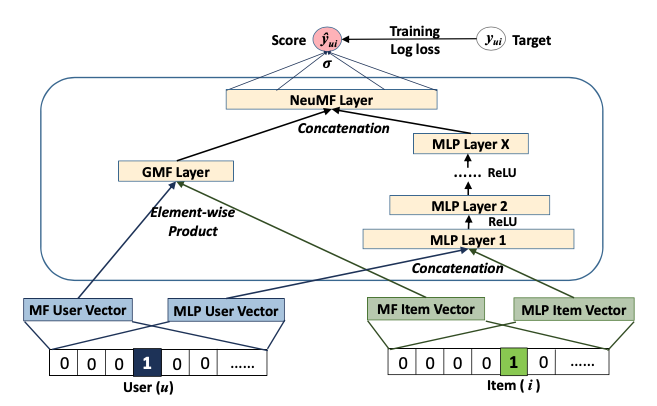

- User Vector는 전체 영화 데이터에서 영화를 평가한 userid를 onehot vector로 나타낸 형태
- Item Vector는 전체 영화 데이터에 등장하는 영화의 id를 onehot vector로 나타낸 형태

논문에서 제시한 모델 구조를 그대로 구현하고 영화 데이터로 실습해본다. 

In [13]:
class FeedForwardEmbedNN(nn.Module):

    def __init__(self, n_users, n_movies, hidden, dropouts, n_factors, embedding_dropout):
        super().__init__()
        self.user_emb = nn.Embedding(n_users, n_factors)
        self.movie_emb = nn.Embedding(n_movies, n_factors)
        self.drop = nn.Dropout(embedding_dropout)
        self.hidden_layers = nn.Sequential(*list(self.generate_layers(n_factors*2, hidden, dropouts)))
        self.fc = nn.Linear(hidden[-1], 1)

    def generate_layers(self, n_factors, hidden, dropouts):
        assert len(dropouts) == len(hidden)

        idx = 0
        while idx < len(hidden):
            if idx == 0:
                yield nn.Linear(n_factors, hidden[idx])
            else:
                yield nn.Linear(hidden[idx-1], hidden[idx])
            yield nn.ReLU()
            yield nn.Dropout(dropouts[idx])

            idx += 1

    def forward(self, users, movies, min_rating=0.5, max_rating=5):
        concat_features = torch.cat([self.user_emb(users), self.movie_emb(movies)], dim=1)
        x = F.relu(self.hidden_layers(concat_features))
        out = torch.sigmoid(self.fc(x))
        out = out * (max_rating - min_rating + 1)

        return out

    def predict(self, users, movies):
        # return the score
        output_scores = self.forward(users, movies)
        return output_scores

In [14]:
class BatchIterator:

    def __init__(self, X, y, batch_size=32, shuffle=True):
        X, y = np.asarray(X), np.asarray(y)

        if shuffle:
            index = np.random.permutation(X.shape[0])
            X, y = X[index], y[index]

        self.X = X
        self.y = y
        self.batch_size = batch_size
        self.shuffle = shuffle
        self.n_batches = int(math.ceil(X.shape[0] // batch_size))
        self._current = 0

    def __iter__(self):
        return self

    def __next__(self):
        return self.next()

    def next(self):
        if self._current >= self.n_batches:
            raise StopIteration()
        k = self._current
        self._current += 1
        bs = self.batch_size
        return self.X[k * bs:(k + 1) * bs], self.y[k * bs:(k + 1) * bs]


In [15]:
def batches(X, y, bs=32, shuffle=True):
    for x_batch, y_batch in BatchIterator(X, y, bs, shuffle):
        x_batch = torch.LongTensor(x_batch)
        y_batch = torch.FloatTensor(y_batch)
        yield x_batch, y_batch.view(-1, 1)

데이터셋과 모델 학습에 필요한 configuration을 입력하고, 학습을 하는 함수를 만든다
configuration을 바꾸면서 모델의 성능을 측정해볼 수 있다. 

In [16]:
def model_train(ds, config):
    X_train, y_train = ds.generate_trainset()
    X_valid, y_valid = ds.generate_valset()
    print(f'TrainSet Info: {ds.num_users} users, {ds.num_movies} movies')

    model = FeedForwardEmbedNN(
        n_users=ds.num_users, n_movies=ds.num_movies,
        n_factors=config['num_factors'], hidden=config['hidden_layers'],
        embedding_dropout=config['embedding_dropout'], dropouts=config['dropouts']
    )

    batch_size = config['batch_size']
    num_epochs = config['num_epochs']
    max_patience = config['total_patience']
    num_patience = 0
    best_loss = np.inf

    device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
    model.to(device)
    criterion = nn.MSELoss(reduction='sum')
    optimizer = optim.Adam(model.parameters(), lr=config['learning_rate'], weight_decay=config['weight_decay'])

    result = dict()
    for epoch in tqdm(range(num_epochs)):
        training_loss = 0.0
        for batch in batches(X_train, y_train, shuffle=True, bs=batch_size):
            x_batch, y_batch = [b.to(device) for b in batch]
            optimizer.zero_grad()
            with torch.set_grad_enabled(True):
                outputs = model(x_batch[:, 0], x_batch[:, 1], ds.min_rating, ds.max_rating)
                loss = criterion(outputs, y_batch)
                loss.backward()
                optimizer.step()
            training_loss += loss.item()
        result['train'] = training_loss / len(X_train)

        # Apply Early Stopping criteria and save best model params
        val_outputs = model(torch.LongTensor(X_valid.user_id.values), torch.LongTensor(X_valid.movie_id.values))
        val_loss = criterion(val_outputs, torch.FloatTensor(y_valid.values).view(-1, 1))
        result['val'] = float((val_loss / len(X_valid)).data)

        if val_loss < best_loss:
            print('Save new model on epoch: %d' % (epoch + 1))
            best_loss = val_loss
            result['best_loss'] = val_loss
            # torch.save(model.state_dict(), 'param.data')
            torch.save(model.state_dict(), config['save_path'])
            num_patience = 0
        else:
            num_patience += 1

        print(f'[epoch: {epoch+1}] train: {result["train"]} - val: {result["val"]}')

        if num_patience >= max_patience:
            print(f"Early Stopped after epoch {epoch+1}")
            break

    return result

In [17]:
def model_valid(user_id_list, movie_id_list):
    dataset = DatasetLoader()
#     test_inputs = read_input()
#     test_input_df = pd.DataFrame(test_inputs, columns=['user_id', 'movie_id']).astype(int)
    processed_test_input_df = pd.DataFrame({
        'user_id': [dataset.user_to_index[x] for x in user_id_list],
        'movie_id': [dataset.movie_to_index[x] for x in movie_id_list]
    })

    # 학습한 모델 load하기 
    my_model = FeedForwardEmbedNN(dataset.num_users, dataset.num_movies,
                       config['hidden_layers'], config['dropouts'], config['num_factors'], config['embedding_dropout'])
    my_model.load_state_dict(torch.load('params.data'))
    prediction_outputs = my_model.predict(users=torch.LongTensor(processed_test_input_df.user_id.values),
                     movies=torch.LongTensor(processed_test_input_df.movie_id.values))

    return prediction_outputs
#     write_output(test_inputs, prediction_outputs)


In [18]:
dataset = DatasetLoader()

In [19]:
config = {
  "num_factors": 250,
  "hidden_layers": [500, 300, 100],
  "embedding_dropout": 0.05,
  "dropouts": [0.3, 0.3, 0.3],
  "learning_rate": 1e-3,
  "weight_decay": 1e-5,
  "batch_size": 64,
  "num_epochs": 5,
  "total_patience": 30,
  "save_path": "params.data"
}

In [20]:
model_train(dataset, config)

  0%|          | 0/5 [00:00<?, ?it/s]

TrainSet Info: 515 users, 6901 movies


 20%|██        | 1/5 [00:33<02:13, 33.46s/it]

Save new model on epoch: 1
[epoch: 1] train: 0.9475029374457508 - val: 0.9877725839614868


 40%|████      | 2/5 [01:01<01:35, 31.77s/it]

Save new model on epoch: 2
[epoch: 2] train: 0.8227788980248182 - val: 0.8192856311798096


 60%|██████    | 3/5 [01:29<01:01, 30.68s/it]

[epoch: 3] train: 0.7596074059397405 - val: 0.8690841197967529


 80%|████████  | 4/5 [02:01<00:31, 31.19s/it]

[epoch: 4] train: 0.7179726343348066 - val: 0.870739221572876


100%|██████████| 5/5 [02:29<00:00, 29.99s/it]

Save new model on epoch: 5
[epoch: 5] train: 0.6845469278437077 - val: 0.8161923289299011


{'train': 0.6845469278437077,
 'val': 0.8161923289299011,
 'best_loss': tensor(1065.1310, grad_fn=<MseLossBackward>)}

In [21]:
movie_id_list = [216,367,556,1047,1131,1147]
user_id = 15
user_id_list = [user_id] * len(movie_id_list)
pred_results = [float(x) for x in model_valid(user_id_list, movie_id_list)]

result_df = pd.DataFrame({
    'userId': user_id_list,
    'movieId': movie_id_list,
    'movieName': [movieName_dict[x] for x in movie_id_list],
    'genres': [genres_dict[x] for x in movie_id_list],
    'pred_ratings': pred_results
})

result_df.sort_values(by='pred_ratings', ascending=False)

,userId,movieId,movieName,genres,pred_ratings
4,15,1131,Jean de Florette (1986),Drama|Mystery,3.961515
5,15,1147,When We Were Kings (1996),Documentary,3.731350
2,15,556,"War Room, The (1993)",Documentary,2.959604
3,15,1047,"Long Kiss Goodnight, The (1996)",Action|Drama|Thriller,2.790639
0,15,216,Billy Madison (1995),Comedy,2.714575
1,15,367,"Mask, The (1994)",Action|Comedy|Crime|Fantasy,2.103795


In [22]:
user_preference(user_id)

,movieId,rating,movieName,genres
userId,,,,
15,4015,5.0,"Dude, Where's My Car? (2000)",Comedy|Sci-Fi
15,1208,5.0,Apocalypse Now (1979),Action|Drama|War
15,296,5.0,Pulp Fiction (1994),Comedy|Crime|Drama|Thriller
15,293,5.0,Léon: The Professional (a.k.a. The Professiona...,Action|Crime|Drama|Thriller
15,3300,5.0,Pitch Black (2000),Horror|Sci-Fi|Thriller
...,...,...,...,...
15,2353,0.5,Enemy of the State (1998),Action|Thriller
15,5464,0.5,Road to Perdition (2002),Crime|Drama
15,485,0.5,Last Action Hero (1993),Action|Adventure|Comedy|Fantasy
